In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import yfinance as yfin
yfin.pdr_override()
from sklearn.preprocessing import MinMaxScaler
import math
from keras.layers import Dense, LSTM

In [4]:
#get the stock quote 
df = pdr.DataReader(name='AAPL', data_source='yahoo', start='2012-01-01', end='2019-12-17')
#show the data 
df.head(3)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732143,14.607143,14.621429,14.686786,302220800.0,12.610315
2012-01-04,14.810000,14.617143,14.642857,14.765714,260022000.0,12.678085
2012-01-05,14.948214,14.738214,14.819643,14.929643,271269600.0,12.818838


In [5]:
#get the number of rows and columns
df.shape #2003 rows and 6 columns 

(2003, 6)

Text(0, 0.5, 'Close')

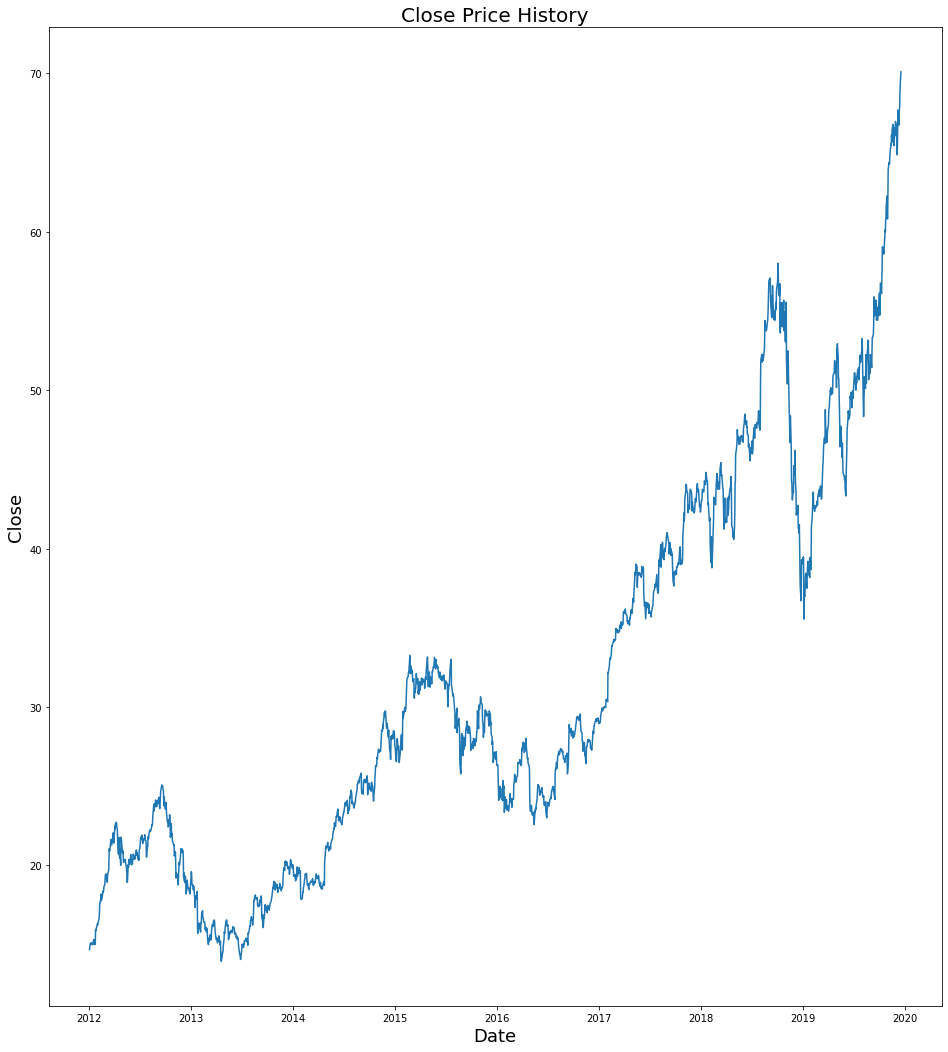

In [6]:
#visualize the closing price history 
plt.figure(figsize=(16,18))
plt.title('Close Price History', fontsize=20)
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close', fontsize=18)

In [7]:
#create a new dataframe with only the close column
data = df.filter(['Close'])

#convert the dataframe into a numpy array
dataset = data.values


#get the number of rows to train the model on
training_data_len = math.ceil(len(dataset) * 0.8)
training_data_len

1603

In [8]:
dataset

array([[14.6867857 ],
       [14.76571369],
       [14.92964268],
       ...,
       [68.78749847],
       [69.96499634],
       [70.10250092]])

In [9]:
#scale the data 
scaler = MinMaxScaler(feature_range=(0,1)) #inclusive, value could be 0, 1 or anything inbetween 
scaled_data = scaler.fit_transform(dataset) #computs min and max values to be used for scaling and transforms 

In [10]:
#create the training dataset 
train_data = scaled_data[0:training_data_len, :] #contains all values from index 0 to train data length, and gets back all of the columns

#split the data into train_x and train_y
x_train, y_train = [],[]

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i , 0]) #contains the first 60 values
    y_train.append(train_data[i, 0]) #contains the 61st value we want to predict
    if i <= 60:
        print(x_train)
        print(y_train)
        print()


[array([0.01316509, 0.01457063, 0.01748985, 0.02026915, 0.01984303,
       0.02080338, 0.02036454, 0.01962679, 0.01862191, 0.02173194,
       0.02453668, 0.02367172, 0.01893355, 0.02345548, 0.01900352,
       0.03569838, 0.03440732, 0.0360927 , 0.03973694, 0.04194384,
       0.0417594 , 0.0410789 , 0.04397903, 0.04670744, 0.04979839,
       0.05479095, 0.0652785 , 0.06543749, 0.07127594, 0.07563885,
       0.06814049, 0.07102789, 0.07097066, 0.07906688, 0.07791571,
       0.08004628, 0.08387497, 0.08600558, 0.09214292, 0.09661394,
       0.09790501, 0.09835659, 0.09071194, 0.08886753, 0.08914103,
       0.09632778, 0.09835024, 0.10269409, 0.11293358, 0.12659476,
       0.12403805, 0.1240444 , 0.13392141, 0.13701237, 0.13481179,
       0.13280207, 0.13070964, 0.13766105, 0.14243103, 0.14442805])]
[0.13949272033425864]



In [11]:
#convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [12]:
x_train

array([[0.01316509, 0.01457063, 0.01748985, ..., 0.13766105, 0.14243103,
        0.14442805],
       [0.01457063, 0.01748985, 0.02026915, ..., 0.14243103, 0.14442805,
        0.13949272],
       [0.01748985, 0.02026915, 0.01984303, ..., 0.14442805, 0.13949272,
        0.13293563],
       ...,
       [0.52177011, 0.51927696, 0.51669488, ..., 0.5857448 , 0.59767603,
        0.5912207 ],
       [0.51927696, 0.51669488, 0.51322235, ..., 0.59767603, 0.5912207 ,
        0.58926183],
       [0.51669488, 0.51322235, 0.51958863, ..., 0.5912207 , 0.58926183,
        0.58164901]])

In [13]:
#reshape the data (expects 3 dimension in form of number of samples, number of timesteps, number of features)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape #now has 3 dimensions 

(1543, 60, 1)

In [14]:
#build the LSTM model
model = tf.keras.Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False,))
model.add(Dense(25))
model.add(Dense(1))

#compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [15]:
#train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1543/1543 [==============================] - 22s 13ms/step - loss: 7.9398e-04


In [16]:
#create the testing dataset
#create a new array containing scaled values from index 1543 to 2003

test_data = scaled_data[training_data_len - 60: , :]

#create the datasets x_test and y_test
x_test = []
y_test = dataset[training_data_len:,:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])



In [17]:
#convert the data into a numpy array
x_test = np.array(x_test)

In [18]:
#Reshape the data 
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [19]:
#Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions) #unscale the values, predictions will contain same values as y_test dataset 

In [20]:
#get the RMSE - a good measure of how accurate the measure predicts the response 
#lower values of RMSE indicate a better fit(use other metrics as well)
RMSE = np.sqrt( np.mean(predictions - y_test) **2)

In [21]:
#plot the data 
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

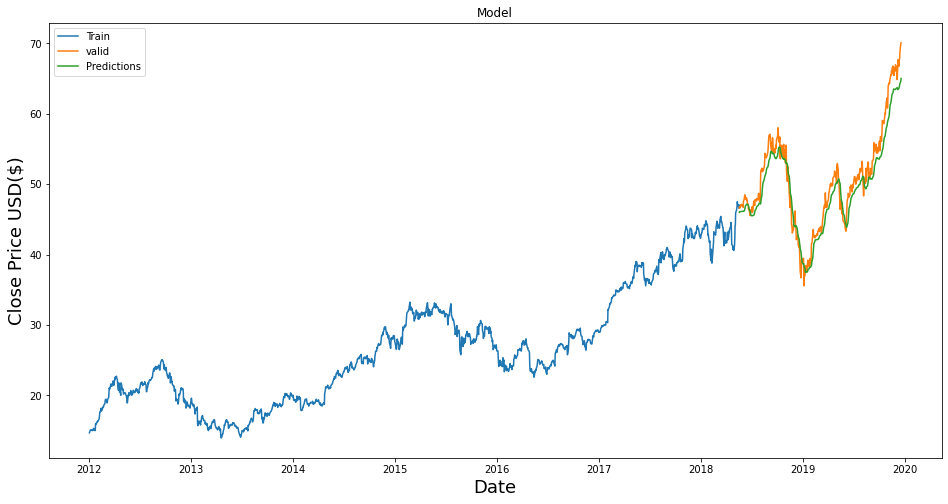

In [22]:
#visualize the model
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'valid', 'Predictions'])

In [23]:
#show the valid and predicted values
valid

,Close,Predictions
Date,,
2018-05-17,46.747501,46.015434
2018-05-18,46.577499,46.092278
2018-05-21,46.907501,46.100666
2018-05-22,46.790001,46.104408
2018-05-23,47.090000,46.092842
...,...,...
2019-12-11,67.692497,63.882584
2019-12-12,67.864998,64.083679
2019-12-13,68.787498,64.302467


In [32]:
#get the quote
apple_quote = pdr.DataReader(name='AAPL', data_source='yahoo', start='2012-01-01', end='2019-12-17')

#create a new dataframe
newdf = apple_quote.filter(['Close'])

#get the last 60 days closing price values and convert the dataframe into an array
last_60_days =  newdf[-60:].values

#scale the data to be inbeteen values of 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)

#create an emtpy list 
X_test = []

#append the past 60 days 
X_test.append(last_60_days_scaled)


In [33]:
#convert the X_test dataset into a numpy array
X_test = np.array(X_test) #so can use in LSTM model 

#reshape data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

#get the predicted scale price 
pred_price = model.predict(X_test)

#undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[65.45481]]


In [34]:
#get the quote
apple_quote2 = pdr.DataReader(name='AAPL', data_source='yahoo', start='2019-12-18', end='2019-12-18')
print(apple_quote2['Close'])

Date
2019-12-18    69.934998
Name: Close, dtype: float64
